In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

dados = pd.read_csv("data/ca-NE-unido.csv")

In [65]:
dados = pd.read_csv("data/ca-NE-unido.csv")

In [66]:

# Mostra o nome das colunas
print("Nomes das colunas:")
print(dados.columns)

Nomes das colunas:
Index(['Regiao - Sigla', 'Estado - Sigla', 'Municipio', 'Revenda',
       'CNPJ da Revenda', 'Nome da Rua', 'Numero Rua', 'Complemento', 'Bairro',
       'Cep', 'Produto', 'Data da Coleta', 'Valor de Venda', 'Valor de Compra',
       'Unidade de Medida', 'Bandeira'],
      dtype='object')


In [67]:
# Verificando quais colunas contêm valores nulos
colunas_nulas = dados.isnull().sum()

# Filtrando para mostrar apenas as colunas que têm valores nulos
colunas_com_nulos = colunas_nulas[colunas_nulas > 0]

print("Colunas com valores nulos:")
print(colunas_com_nulos)

Colunas com valores nulos:
Numero Rua            252
Complemento        248206
Bairro                445
Valor de Compra    354852
dtype: int64


## Pre-Processamento

In [68]:
dados['Data da Coleta'] = pd.to_datetime(dados['Data da Coleta'], format='%d/%m/%Y')
dados['Valor de Venda'] = dados['Valor de Venda'].str.replace(',', '.', regex=False).astype(float)
dados = dados[dados['Produto'] == 'GASOLINA']
# usar dados somente do ceara

dados.set_index('Data da Coleta', inplace=True)

dados['Ano'] = dados.index.year.astype(float)

dados['Mes'] = dados.index.month.astype(float)

dados = dados.drop(columns=['Valor de Compra'])
dados = dados.drop(columns=['Numero Rua'])
dados = dados.drop(columns=['Complemento'])
dados = dados.drop(columns=['CNPJ da Revenda'])


dados_semanal = dados['Valor de Venda'].resample('W').mean()

print(len(dados))

89017


In [69]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd

# Definindo colunas categóricas e numéricas
categorical_features = ['Estado - Sigla', 'Municipio', 'Bandeira']
numeric_features = ['Ano', 'Mes']

# Separando as features e o target
X = dados[categorical_features + numeric_features]
y = dados['Valor de Venda']

# Salvando os índices originais
indices_originais = X.index

# Dividindo os dados em treino e teste
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=False)

# Agora, dividimos o conjunto de treino completo em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42, shuffle=False)

# Configurando o pré-processador para normalizar as colunas numéricas e aplicar OneHotEncoding nas categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Normalização das features numéricas
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # OneHotEncoding das features categóricas
    ])

# Criando o pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Aplicando o pipeline aos dados de treino
X_train_transformed = pipeline.fit_transform(X_train)
X_val_transformed = pipeline.transform(X_val)
X_test_transformed = pipeline.transform(X_test)

# Convertendo as matrizes esparsas para DataFrames, preservando os índices
X_train_transformed_df = pd.DataFrame(X_train_transformed.toarray(), 
                                      columns=pipeline.named_steps['preprocessor'].get_feature_names_out(),
                                      index=X_train.index)

X_val_transformed_df = pd.DataFrame(X_val_transformed.toarray(), 
                                    columns=pipeline.named_steps['preprocessor'].get_feature_names_out(),
                                    index=X_val.index)

X_test_transformed_df = pd.DataFrame(X_test_transformed.toarray(), 
                                     columns=pipeline.named_steps['preprocessor'].get_feature_names_out(),
                                     index=X_test.index)

# Verificando se os índices são preservados

#print(X_train_transformed_df.index[:5])
#print(y_train.index[:5])


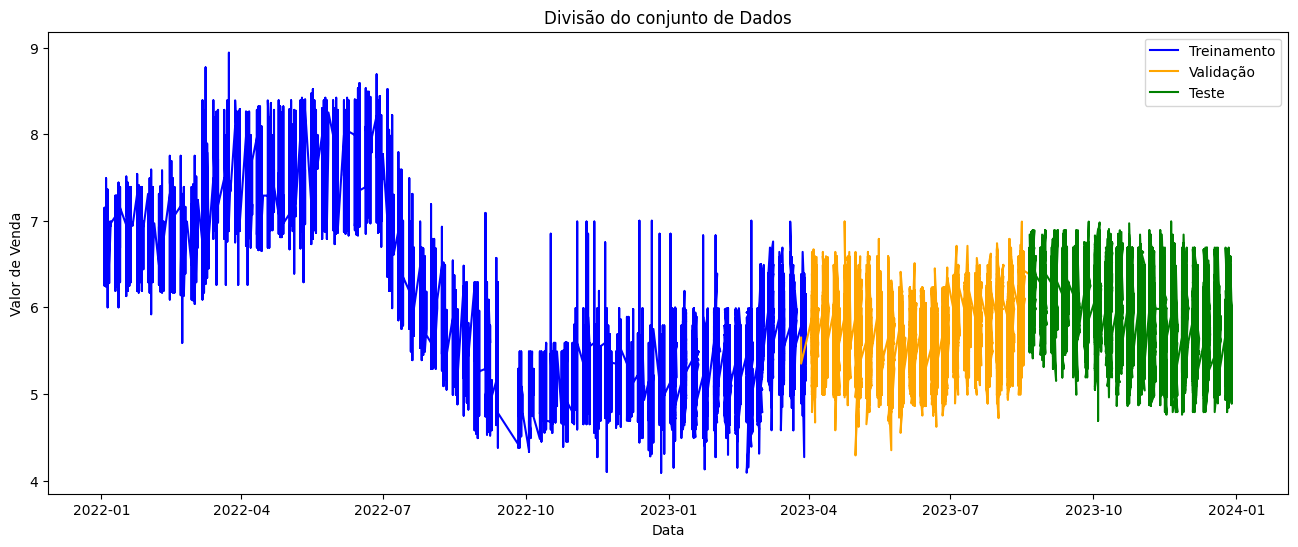

In [70]:
plt.figure(figsize=(16,6))

plt.title("Divisão do conjunto de Dados")

plt.plot(y_train,label='Treinamento', color='blue')
plt.plot(y_val,label='Validação', color='orange')
plt.plot(y_test,label='Teste', color='green')

plt.xlabel("Data")
plt.ylabel("Valor de Venda")
plt.legend()

plt.show()

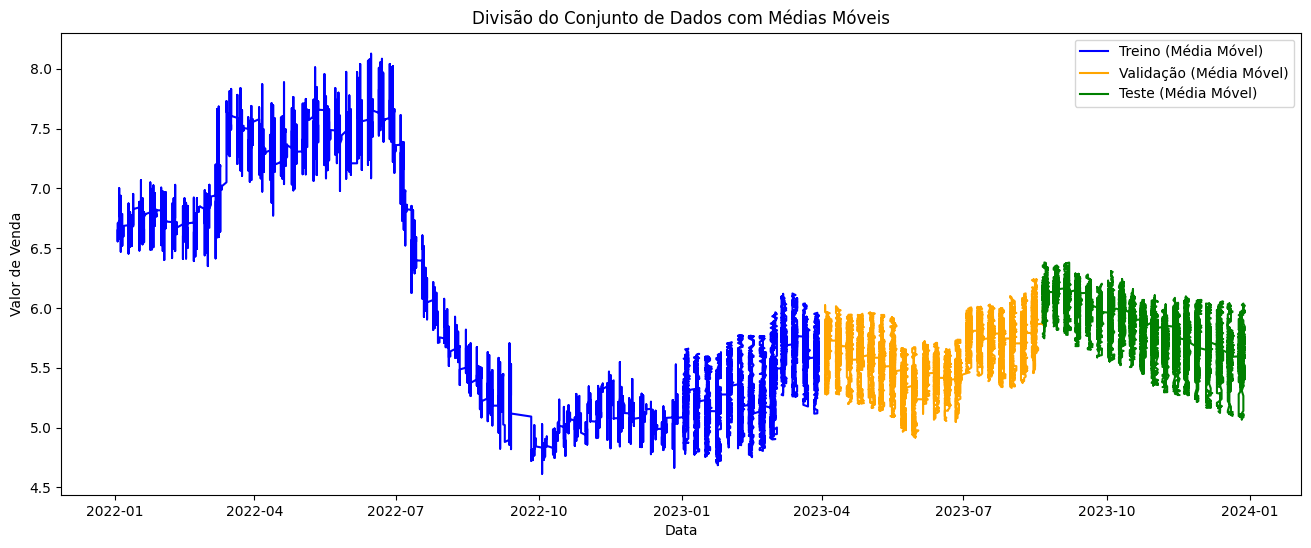

In [71]:
# Aplicando médias móveis com uma janela de 10 períodos (por exemplo)
y_train_rolling = y_train.rolling(window=30).mean()
y_val_rolling = y_val.rolling(window=30).mean()
y_test_rolling = y_test.rolling(window=30).mean()

# Plotando as médias móveis
plt.figure(figsize=(16, 6))

plt.title("Divisão do Conjunto de Dados com Médias Móveis")

plt.plot(y_train_rolling, label='Treino (Média Móvel)', color='blue')
plt.plot(y_val_rolling, label='Validação (Média Móvel)', color='orange')
plt.plot( y_test_rolling, label='Teste (Média Móvel)', color='green')

plt.xlabel("Data")
plt.ylabel("Valor de Venda")
plt.legend()

plt.show()


## Análise de Autocorrelação

<function matplotlib.pyplot.show(close=None, block=None)>

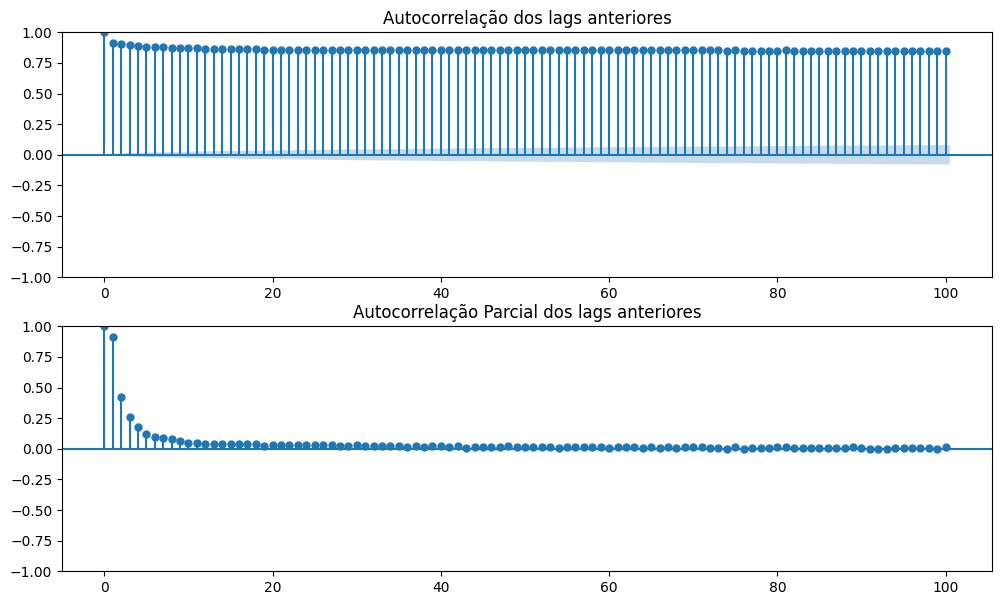

In [72]:
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(211)
fig = plot_acf(dados['Valor de Venda'], lags=100, ax=ax1)
ax1.set_title("Autocorrelação dos lags anteriores")

ax2 = fig.add_subplot(212)
fig = plot_pacf(dados['Valor de Venda'], lags=100, ax=ax2)
ax2.set_title("Autocorrelação Parcial dos lags anteriores")

plt.show

# Devo continuar usando os Dados completos aqui?

Lags Significantes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 77, 79, 80, 81, 82, 83, 84, 86, 88, 89, 90, 95, 97, 100]


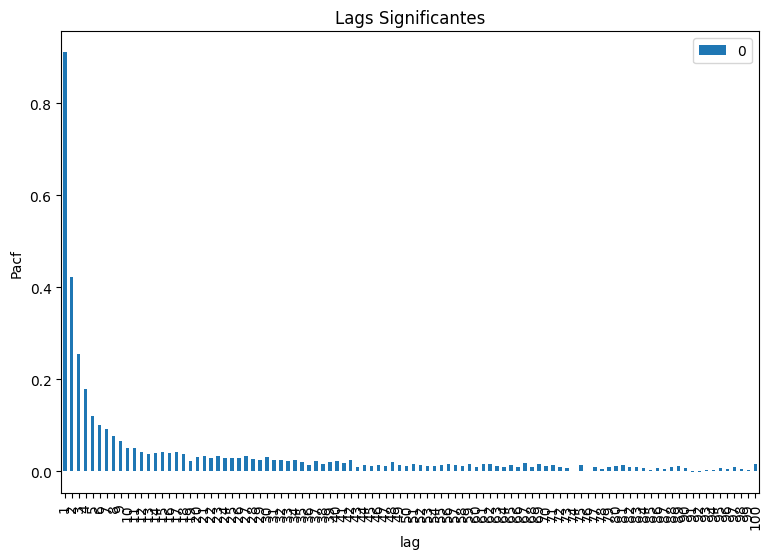

In [73]:
from statsmodels.tsa.stattools import pacf

def getSignificantLags(y, nLags = 5, alpha=0.05):
    Pacf, Pacf_intervalos =  pacf(x=y, nlags=nLags, alpha=alpha)
    pd.DataFrame(Pacf)[1:].plot(kind='bar', figsize=(9,6), legend='pacf valores',
                               xlabel='lag', ylabel='Pacf');
    significantLags = []
    for i in range(1, len(Pacf)):
        # print(pac[i], pac_ci[i][0], pac_ci[i][1])
        if Pacf[i] < Pacf_intervalos[i][0] - Pacf[i] or Pacf[i] > Pacf_intervalos[i][1] - Pacf[i]:
            significantLags.append(i)
    print('Lags Significantes:', significantLags)
    return significantLags

e1_significantLags = getSignificantLags(dados['Valor de Venda'], nLags = 100, alpha=0.05)
plt.title("Lags Significantes")
plt.show()
# Colocar 100 de valores de lag

## Tranformação dos Dados

In [74]:
'''from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline



from sklearn.model_selection import train_test_split

# Definindo colunas categóricas e numéricas
categorical_features = ['Estado - Sigla', 'Municipio', 'Bandeira']
numeric_features = ['Ano', 'Mes']

# Separando as features e o target
X = dados[categorical_features + numeric_features]
y = dados['Valor de Venda']


# Salvando os índices originais
indices_originais = X.index

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Normalização das features numéricas
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # OneHotEncoding das features categóricas
    ])

# Criando o pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Aplicando o pipeline aos dados
X_transformed = pipeline.fit_transform(X)

# Convertendo a matriz esparsa para DataFrame, preservando os índices
X_transformed_df = pd.DataFrame(X_transformed.toarray(), 
                                columns=pipeline.named_steps['preprocessor'].get_feature_names_out(),
                                index=indices_originais)

# Dividindo os dados em conjuntos de treino e teste, preservando os índices
X_train, X_test, y_train, y_test = train_test_split(X_transformed_df, y, test_size=0.33, random_state=42, shuffle=False)

# Verificando se os índices são preservados
print(X_train.index[:5])
print(y_train.index[:5])'''



"from sklearn.compose import ColumnTransformer\nfrom sklearn.preprocessing import OneHotEncoder\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.pipeline import Pipeline\n\n\n\nfrom sklearn.model_selection import train_test_split\n\n# Definindo colunas categóricas e numéricas\ncategorical_features = ['Estado - Sigla', 'Municipio', 'Bandeira']\nnumeric_features = ['Ano', 'Mes']\n\n# Separando as features e o target\nX = dados[categorical_features + numeric_features]\ny = dados['Valor de Venda']\n\n\n# Salvando os índices originais\nindices_originais = X.index\n\npreprocessor = ColumnTransformer(\n    transformers=[\n        ('num', StandardScaler(), numeric_features),  # Normalização das features numéricas\n        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # OneHotEncoding das features categóricas\n    ])\n\n# Criando o pipeline\npipeline = Pipeline(steps=[\n    ('preprocessor', preprocessor)\n])\n\n# Aplicando o pipeline aos dados\nX_transfor

## Modelagem

In [75]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Inicializando o modelo
reg = DecisionTreeRegressor()

# Treinando o modelo
reg.fit(X_train_transformed_df, y_train.values.ravel())  # Convertendo y_train para um array 1D

# Fazendo previsões
predicao = reg.predict(X_val_transformed_df)

# Garantindo que y_val seja uma Series e não um DataFrame
y_val_series = y_val.values.ravel()  # Convertendo y_val para um array 1D

# Calculando a diferença entre os valores reais e previstos
diferenca = mean_squared_error(y_val_series, predicao)

# Se você precisar imprimir ou fazer algo com a diferença
print(f"MSE (Mean Squared Error): {diferenca}")


MSE (Mean Squared Error): 0.09281297664848975


In [87]:
# Fazendo previsões
predicao = reg.predict(X_val_transformed_df)


# Criando um DataFrame com valores reais e previstos, mantendo os índices
df_comparacao = pd.DataFrame({
    'Valor Real': y_val_series,
    'Valor Previsto': predicao
}, index=y_val.index)

# Mostrando o DataFrame
display(df_comparacao)


,Valor Real,Valor Previsto
Data da Coleta,,
2023-03-27,5.65,5.620345
2023-03-27,5.35,5.363333
2023-04-04,5.95,5.790667
2023-04-03,5.68,5.790667
2023-04-04,5.74,5.586667
...,...,...
2023-08-22,6.27,5.534815
2023-08-22,6.29,5.588333
2023-08-22,6.29,5.588333


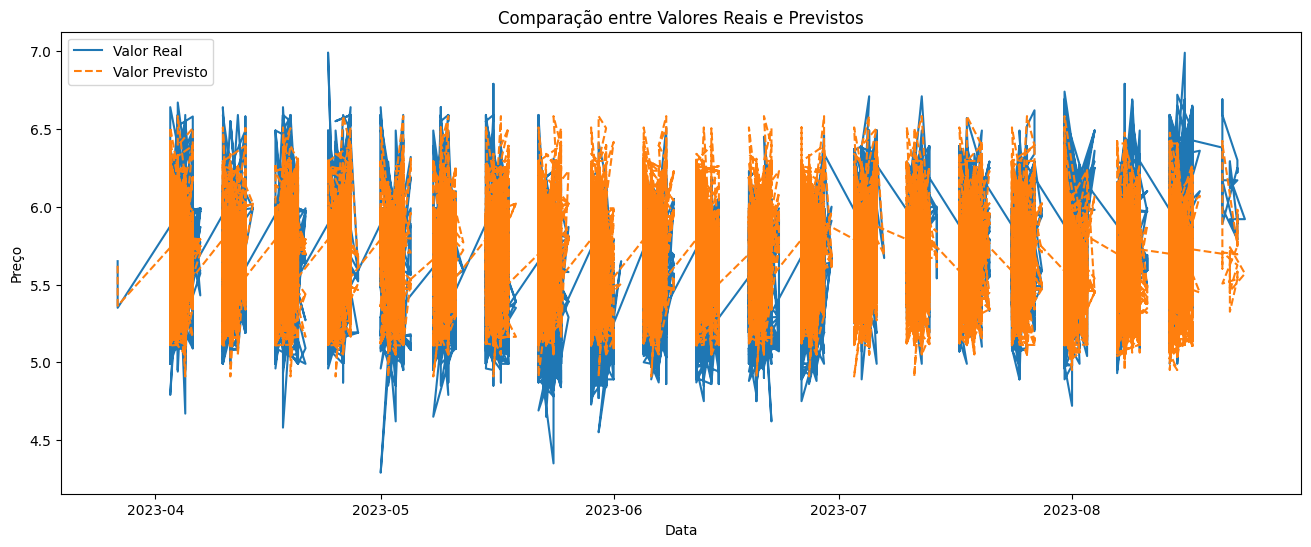

In [88]:
# Plotando os resultados
plt.figure(figsize=(16, 6))
plt.plot(df_comparacao['Valor Real'], label='Valor Real')
plt.plot(df_comparacao['Valor Previsto'], label='Valor Previsto', linestyle='--')
plt.title('Comparação entre Valores Reais e Previstos')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()


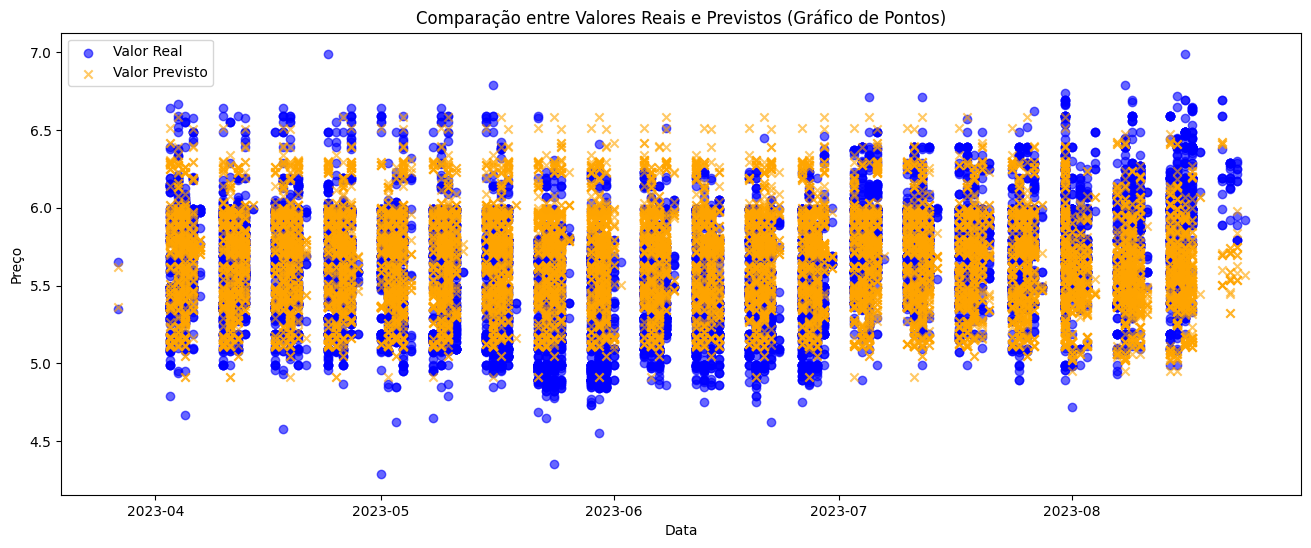

In [98]:
import matplotlib.pyplot as plt

# Criando um gráfico de pontos
plt.figure(figsize=(16, 6))
plt.scatter(df_comparacao.index, df_comparacao['Valor Real'], label='Valor Real', color='blue', alpha=0.6)
plt.scatter(df_comparacao.index, df_comparacao['Valor Previsto'], label='Valor Previsto', color='orange', alpha=0.6, marker='x')
plt.title('Comparação entre Valores Reais e Previstos (Gráfico de Pontos)')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()
